In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [2]:
df=pd.read_csv('/Users/michaelrosen/Desktop/Housing_Modeling/Data/JOINED_CENSUS_LISTINGS_MAY_27.csv')

In [3]:
colstokeep=['posted','post title','neighborhood','URL','price','latlon','y','x']

In [4]:
df=df[colstokeep]

In [5]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.x, df.y))

In [6]:
df2=gpd.read_file('/Users/michaelrosen/Desktop/Housing_Modeling/Data/Grand_Gdf.geojson')

In [7]:
model=gpd.sjoin(gdf.set_crs(epsg=4326),df2)

In [8]:
model=model.dropna()

In [9]:
model_test = model.drop_duplicates(subset = ["post title"])

In [10]:
model_test['high_ed']=model_test['PctBachelor']+model_test['PctMasters']+model_test['PctDoctorate']

/Users/michaelrosen/opt/anaconda3/envs/uds/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [11]:
model_test['price'] = model_test['price'].str.replace(',','')

In [12]:
model_test['price']= model_test['price'].apply(pd.to_numeric, errors='coerce')

In [13]:
model_test.head()

,posted,post title,neighborhood,URL,price,latlon,y,x,geometry,index_right,...,EducDoct,PctNHW,PctBlackAA,PctAsian,pctPOC,PctBachelor,PctMasters,PctDoctorate,permit_count,high_ed
3,2022-05-25 12:16,Recently Updated 3 Bedroom 2 Bath Quiet Walk S...,(Venice Beach),https://losangeles.craigslist.org/wst/apa/d/ve...,5500,"['33.980825', '-118.467207']",33.980825,-118.467207,POINT (-118.46721 33.98083),59,...,99.0,87.822791,1.800521,3.837953,12.177209,43.043599,23.965565,2.749236,48.0,69.7584
5,2022-05-25 12:15,Large 3 Bedroom 2 Bath on Quiet Walk Street St...,(Venice),https://losangeles.craigslist.org/wst/apa/d/ve...,5500,"['33.980825', '-118.467207']",33.980825,-118.467207,POINT (-118.46721 33.98083),59,...,99.0,87.822791,1.800521,3.837953,12.177209,43.043599,23.965565,2.749236,48.0,69.7584
6,2022-05-25 10:55,"2 bed, 1 bath upper unit on canals",(Venice),https://losangeles.craigslist.org/wst/apa/d/ve...,3990,"['33.984666', '-118.463795']",33.984666,-118.463795,POINT (-118.46380 33.98467),59,...,99.0,87.822791,1.800521,3.837953,12.177209,43.043599,23.965565,2.749236,48.0,69.7584
7,2022-05-25 10:32,"Fitness Center, Sundeck, Newly Renovated, Stud...",(Close to the Beach),https://losangeles.craigslist.org/wst/apa/d/ve...,2850,"['33.981644', '-118.463038']",33.981644,-118.463038,POINT (-118.46304 33.98164),59,...,99.0,87.822791,1.800521,3.837953,12.177209,43.043599,23.965565,2.749236,48.0,69.7584
8,2022-05-25 09:05,Brand New Studio! 5 Blocks from Beach!,(Marina del Rey),https://losangeles.craigslist.org/wst/apa/d/ve...,2250,"['33.982676', '-118.461387']",33.982676,-118.461387,POINT (-118.46139 33.98268),59,...,99.0,87.822791,1.800521,3.837953,12.177209,43.043599,23.965565,2.749236,48.0,69.7584


In [14]:
xvars = ['permit_count', 'high_ed','PctNHW','PctBlackAA','PctAsian','pctPOC','Median HHI']
yvar = 'price'
X_train, X_test, y_train, y_test = train_test_split(
    model_test[xvars], model_test[yvar], test_size = 0.3, random_state = 1)

In [15]:
rf = RandomForestRegressor(n_estimators = 50, random_state = 1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [16]:
np.abs(y_pred-y_test).sum()

880938.6702366977

In [17]:
a=y_test
e=y_pred
c=np.array(y_test)
d=np.array(y_pred)
m, b = np.polyfit(c, d, 1)

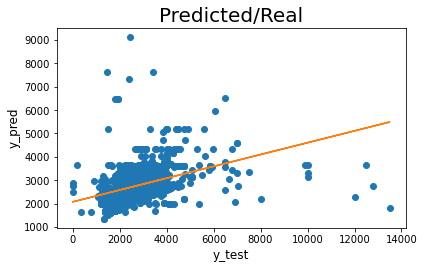

In [18]:
plt.plot(a,e,'o')
plt.plot(c, m*c + b)
plt.title(label="Predicted/Real",
          fontsize=20,
          color="black",)
plt.xlabel('y_test', fontsize=12)
plt.ylabel('y_pred', fontsize=12)
plt.tight_layout()
plt.subplots_adjust(top=0.85)

In [19]:
np.corrcoef(y_pred,y_test)

array([[1.        , 0.40420003],
       [0.40420003, 1.        ]])

Text(0, 0.5, 'Percent contribution')

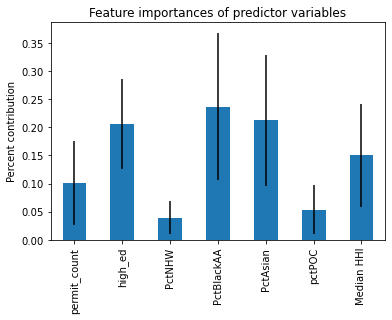

In [20]:
importances = rf.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances of predictor variables")
ax.set_ylabel("Percent contribution")

In [21]:
xvars2 = ['high_ed','PctBlackAA','PctAsian','Median HHI']
yvar2 = 'price'
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    model_test[xvars2], model_test[yvar2], test_size = 0.3, random_state = 1)

In [22]:
a2=y_test
e2=y_pred
c2=np.array(y_test)
d2=np.array(y_pred)
m2, b2 = np.polyfit(c2, d2, 1)

In [23]:
rf2 = RandomForestRegressor(n_estimators = 50, random_state = 1)
rf2.fit(X_train2, y_train2)
y_pred2 = rf2.predict(X_test2)

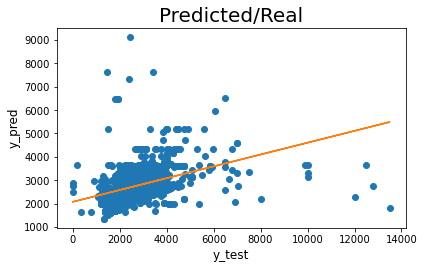

In [24]:
plt.plot(a2,e2,'o')
plt.plot(c2, m2*c2 + b2)
plt.title(label="Predicted/Real",
          fontsize=20,
          color="black",)
plt.xlabel('y_test', fontsize=12)
plt.ylabel('y_pred', fontsize=12)
plt.tight_layout()
plt.subplots_adjust(top=0.85)

In [25]:
np.corrcoef(y_pred2,y_test2)

array([[1.        , 0.40408934],
       [0.40408934, 1.        ]])

Text(17.200000000000003, 0.5, 'Percent contribution')

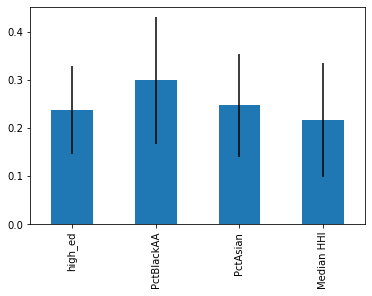

In [29]:
importances2 = rf2.feature_importances_
forest_importances2 = pd.Series(importances2, index=X_train2.columns)
std2 = np.std([tree.feature_importances_ for tree in rf2.estimators_], axis=0)
fig2, ax2 = plt.subplots()
forest_importances2.plot.bar(yerr=std2, ax=ax2)
ax.set_title("Feature importances of predictor variables")
ax.set_ylabel("Percent contribution")